# <font color = 'blue'> Predicting real-time financial assets with pyspark and machine learning </font>

In [1]:
# Python Language version
from platform import python_version
print('Python Version used in this Jupyter Notebook:', python_version())

Python Version used in this Jupyter Notebook: 3.9.7


In [2]:
# Findspark
import findspark
findspark.init()

In [3]:
# Import libraries and packages
import pyspark
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [4]:
# Output Format
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [5]:
# Versions in this Jupyter Notebook
%reload_ext watermark
%watermark -a "Libraries Versions" --iversions

Author: Libraries Versions

findspark : 2.0.1
numpy     : 1.20.3
pyspark   : 3.3.0
seaborn   : 0.11.2
matplotlib: 3.4.3
pandas    : 1.3.4



## Working on Spark Environment

In [6]:
# Defining the random seed in order to reproduce the same outputs of this notebook
random_seed = 10
np.random.seed = random_seed
np.random.set_state = random_seed

In [7]:
# Creating the spark context
sc = SparkContext(appName = 'Financial Project')

In [8]:
# Creating Spark Session
spark_session = SparkSession.Builder().getOrCreate()

In [9]:
# Viewing the spark session object
spark_session

In [10]:
# Loading the data to the session
# Dataset: Ethereum Prices from 2015-08-07 to 2023-01-30
df_spark = spark_session.read.csv('data/ethereumprice.csv', header = 'true', inferSchema='True')

In [11]:
# Object type
type(df_spark)

pyspark.sql.dataframe.DataFrame

In [12]:
# Viewing the data
df_spark.show()

+----------+------------------+------------------+------------------+------------------+
| timestamp|              open|              high|               low|             close|
+----------+------------------+------------------+------------------+------------------+
|1675036800| 1644.930737429701|         undefined|         undefined|         undefined|
|1674950400|1572.3284596132792|1656.7355616828581|1567.2505554599768|1646.3975912377196|
|1674864000|1597.7988155004043|1606.3350413485482| 1561.682974973507| 1573.408539327373|
|1674777600|1601.1149228955474|  1621.57130439506|  1560.42851740301|1597.8047515450849|
|1674691200|1612.7316140076332| 1630.884432341589|1582.3077746034123| 1602.892667469686|
|1674691140|  1612.94610357018|         undefined|         undefined|         undefined|
|1674604800| 1556.101281767276|1637.3678615600288|1523.9638869237974|1614.2550742006724|
|1674518400|1626.5364549162935|1640.9718885044706|1545.4960002719436|1556.0225540840077|
|1674432000|1627.8865

In [13]:
# Viewing the metadata (schema)
df_spark.printSchema()

root
 |-- timestamp: integer (nullable = true)
 |-- open: double (nullable = true)
 |-- high: string (nullable = true)
 |-- low: string (nullable = true)
 |-- close: string (nullable = true)



We can see that some attributes do not correspond to the real data type 

In [14]:
# Checking the number of rows
df_spark.count()

3123

<b>Some alternative ways to convert atributes to the proper type:</b>

In [15]:
# Lets convert the columns to the proper data type
df_spark = df_spark.withColumn("high", df_spark.high.cast('double'))
df_spark = df_spark.withColumn("low", df_spark.low.cast('double'))
df_spark = df_spark.withColumn("close", df_spark.close.cast('double'))

In [16]:
df_spark.printSchema()

root
 |-- timestamp: integer (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)



In [17]:
# Another way to convert data types
columns_to_cast = ['high', 'low', 'close']
df_temp = (df_spark.select(*(c for c in df_spark.columns if c not in columns_to_cast),
                           *(F.col(c).cast("double").alias(c) for c in columns_to_cast)))

In [18]:
df_temp.printSchema()

root
 |-- timestamp: integer (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)



## Data Wrangling with SparkSQL

In [17]:
# We will create a temporary table from the dataframe
# Temporary tables are useful when we want dataset visibility to the others Spark Sessions
df_spark.createOrReplaceTempView('ethereum_data')

In [18]:
# We execute a SQL query
df_ethereum = spark_session.sql("SELECT *,\
                                 FROM_unixtime(timestamp) AS `dateTime`\
                                 FROM ethereum_data")

In [19]:
type(df_ethereum)

pyspark.sql.dataframe.DataFrame

In [23]:
# Removing null/missing values
df_ethereum = df_ethereum.dropna('any')

In [24]:
# Checking them again
df_ethereum.show(20)

+----------+------------------+------------------+------------------+------------------+-------------------+
| timestamp|              open|              high|               low|             close|           dateTime|
+----------+------------------+------------------+------------------+------------------+-------------------+
|1674950400|1572.3284596132792|1656.7355616828581|1567.2505554599768|1646.3975912377196|2023-01-28 21:00:00|
|1674864000|1597.7988155004043|1606.3350413485482| 1561.682974973507| 1573.408539327373|2023-01-27 21:00:00|
|1674777600|1601.1149228955474|  1621.57130439506|  1560.42851740301|1597.8047515450849|2023-01-26 21:00:00|
|1674691200|1612.7316140076332| 1630.884432341589|1582.3077746034123| 1602.892667469686|2023-01-25 21:00:00|
|1674604800| 1556.101281767276|1637.3678615600288|1523.9638869237974|1614.2550742006724|2023-01-24 21:00:00|
|1674518400|1626.5364549162935|1640.9718885044706|1545.4960002719436|1556.0225540840077|2023-01-23 21:00:00|
|1674432000|1627.88

In [25]:
# Checking the number of rows again
df_ethereum.count()

1431

In [26]:
# Data Loss: 3123 / 1431
print('Data Loss (%): ', 100 - ((1431/3123) * 100))

Data Loss (%):  54.178674351585016


dateTime column provides details related to the quotation. Let's split the elements of the date in different columns.

In [105]:
# Split datetime
df_date = df_ethereum.withColumn('date', F.split(F.col('dateTime'), ' ').getItem(0))

In [106]:
type(df_date)

pyspark.sql.dataframe.DataFrame

In [107]:
# Let's check the schema
df_date.printSchema()

root
 |-- timestamp: integer (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- date: string (nullable = true)



In [108]:
# Viewing the data
df_date.show()

+----------+------------------+------------------+------------------+------------------+-------------------+----------+
| timestamp|              open|              high|               low|             close|           dateTime|      date|
+----------+------------------+------------------+------------------+------------------+-------------------+----------+
|1674950400|1572.3284596132792|1656.7355616828581|1567.2505554599768|1646.3975912377196|2023-01-28 21:00:00|2023-01-28|
|1674864000|1597.7988155004043|1606.3350413485482| 1561.682974973507| 1573.408539327373|2023-01-27 21:00:00|2023-01-27|
|1674777600|1601.1149228955474|  1621.57130439506|  1560.42851740301|1597.8047515450849|2023-01-26 21:00:00|2023-01-26|
|1674691200|1612.7316140076332| 1630.884432341589|1582.3077746034123| 1602.892667469686|2023-01-25 21:00:00|2023-01-25|
|1674604800| 1556.101281767276|1637.3678615600288|1523.9638869237974|1614.2550742006724|2023-01-24 21:00:00|2023-01-24|
|1674518400|1626.5364549162935|1640.9718

We can see in df_date that all registers have the same hour, so this information is not relevant and we can discard it

In [109]:
# We will adjust the date format to extract the day of the week
df_date = df_date.withColumn('date', df_date['date'].cast(DateType())).\
                  withColumn('dateTime', df_date['dateTime'].cast(DateType()))

In [110]:
df_date.show(10)

+----------+------------------+------------------+------------------+------------------+----------+----------+
| timestamp|              open|              high|               low|             close|  dateTime|      date|
+----------+------------------+------------------+------------------+------------------+----------+----------+
|1674950400|1572.3284596132792|1656.7355616828581|1567.2505554599768|1646.3975912377196|2023-01-28|2023-01-28|
|1674864000|1597.7988155004043|1606.3350413485482| 1561.682974973507| 1573.408539327373|2023-01-27|2023-01-27|
|1674777600|1601.1149228955474|  1621.57130439506|  1560.42851740301|1597.8047515450849|2023-01-26|2023-01-26|
|1674691200|1612.7316140076332| 1630.884432341589|1582.3077746034123| 1602.892667469686|2023-01-25|2023-01-25|
|1674604800| 1556.101281767276|1637.3678615600288|1523.9638869237974|1614.2550742006724|2023-01-24|2023-01-24|
|1674518400|1626.5364549162935|1640.9718885044706|1545.4960002719436|1556.0225540840077|2023-01-23|2023-01-23|
|

In [111]:
# We will extract the day of the week
df_date_dayWeek = df_date.withColumn('day_of_week', F.dayofweek(df_date.date))

In [112]:
df_date_dayWeek.printSchema()

root
 |-- timestamp: integer (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- dateTime: date (nullable = true)
 |-- date: date (nullable = true)
 |-- day_of_week: integer (nullable = true)



In [113]:
# Let's extract the year of the quotation
# We will apply a method that extract the first position of the column date
df_date_year = df_date_dayWeek.withColumn('year', F.split(F.col('date'), '-').getItem(0))

In [114]:
df_date_year.show(10)

+----------+------------------+------------------+------------------+------------------+----------+----------+-----------+----+
| timestamp|              open|              high|               low|             close|  dateTime|      date|day_of_week|year|
+----------+------------------+------------------+------------------+------------------+----------+----------+-----------+----+
|1674950400|1572.3284596132792|1656.7355616828581|1567.2505554599768|1646.3975912377196|2023-01-28|2023-01-28|          7|2023|
|1674864000|1597.7988155004043|1606.3350413485482| 1561.682974973507| 1573.408539327373|2023-01-27|2023-01-27|          6|2023|
|1674777600|1601.1149228955474|  1621.57130439506|  1560.42851740301|1597.8047515450849|2023-01-26|2023-01-26|          5|2023|
|1674691200|1612.7316140076332| 1630.884432341589|1582.3077746034123| 1602.892667469686|2023-01-25|2023-01-25|          4|2023|
|1674604800| 1556.101281767276|1637.3678615600288|1523.9638869237974|1614.2550742006724|2023-01-24|2023-

In [115]:
# Checking the final schema
df_date_year.printSchema()

root
 |-- timestamp: integer (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- dateTime: date (nullable = true)
 |-- date: date (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- year: string (nullable = true)



In [116]:
# COnverting the pyspark scaled dataframe to a Pandas dataframe
df_pandas = df_date_year.toPandas()

In [117]:
# Checking it
df_pandas.head()

,timestamp,open,high,low,close,dateTime,date,day_of_week,year
0,1674950400,1572.328460,1656.735562,1567.250555,1646.397591,2023-01-28,2023-01-28,7,2023
1,1674864000,1597.798816,1606.335041,1561.682975,1573.408539,2023-01-27,2023-01-27,6,2023
2,1674777600,1601.114923,1621.571304,1560.428517,1597.804752,2023-01-26,2023-01-26,5,2023
3,1674691200,1612.731614,1630.884432,1582.307775,1602.892667,2023-01-25,2023-01-25,4,2023
4,1674604800,1556.101282,1637.367862,1523.963887,1614.255074,2023-01-24,2023-01-24,3,2023


In [118]:
type(df_pandas)

pandas.core.frame.DataFrame

In [119]:
df_pandas.dtypes

timestamp        int32
open           float64
high           float64
low            float64
close          float64
dateTime        object
date            object
day_of_week      int32
year            object
dtype: object

In [120]:
# Split the values in the last column into separate columns
df1_pandas = df_pandas.loc[:, ['timestamp', 'open', 'high', 'low', 'close', 'date', 'day_of_week']]
df1_pandas.head()

,timestamp,open,high,low,close,date,day_of_week
0,1674950400,1572.328460,1656.735562,1567.250555,1646.397591,2023-01-28,7
1,1674864000,1597.798816,1606.335041,1561.682975,1573.408539,2023-01-27,6
2,1674777600,1601.114923,1621.571304,1560.428517,1597.804752,2023-01-26,5
3,1674691200,1612.731614,1630.884432,1582.307775,1602.892667,2023-01-25,4
4,1674604800,1556.101282,1637.367862,1523.963887,1614.255074,2023-01-24,3


Pyspark environment is not suitable for exploratory analysis so we will convert the dataframe to Pandas in order to make easier the exploratory analysis

## Exploratory Analysis

<AxesSubplot:>

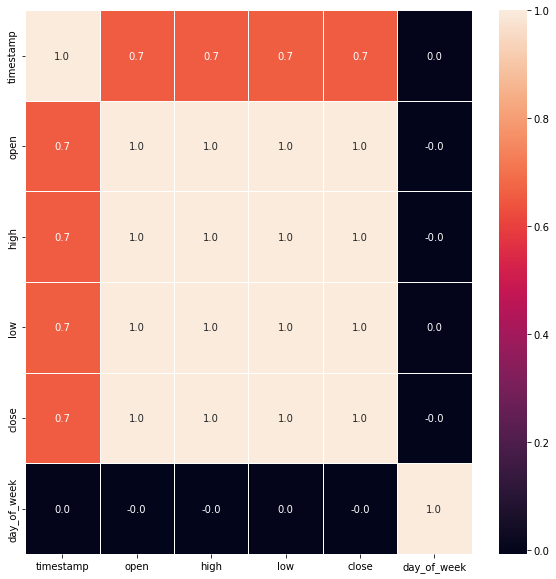

In [43]:
# Using a Heatmap to view correlations
corr = df1_pandas.corr()
f, ax = plt.subplots(figsize = (10,10))
sns.heatmap(corr, annot = True, linewidths = 0.5, fmt = '0.01f', ax = ax)

Insights about the correlation plot:
<br/>
<br/>
- We can see a strong relation between the target variable (close) and timestamp but timestamp works as ID within every quotation registered so it is not a worth information
<br/>
<br/>
- We observed a strong correlation between "Close" and all input variables Open, High and Low, as we expected

Let's analyze the correlation between the predictor variables.

Let's analyze the Open variable (opening quotation of the trading session), we see a very high correlation between this variable and the other variables that indicate ethereum price (High, Low).

This indicates a multicollinearity problem. This makes a lot of sense as they are variables that indicate the same information (quotation price). If we pass all these variables to the model, we will be reinforcing this information, making it biased.

We applied a standard scale to plot the correlation but we will use date information to explore the dataset so we will use another pyspark dataframe converted to pandas:

In [121]:
# Converting the pyspark dataframe with date information to Pandas
df_pandas_Dates = df_date_year.toPandas()

In [122]:
df_pandas_Dates.head()

,timestamp,open,high,low,close,dateTime,date,day_of_week,year
0,1674950400,1572.328460,1656.735562,1567.250555,1646.397591,2023-01-28,2023-01-28,7,2023
1,1674864000,1597.798816,1606.335041,1561.682975,1573.408539,2023-01-27,2023-01-27,6,2023
2,1674777600,1601.114923,1621.571304,1560.428517,1597.804752,2023-01-26,2023-01-26,5,2023
3,1674691200,1612.731614,1630.884432,1582.307775,1602.892667,2023-01-25,2023-01-25,4,2023
4,1674604800,1556.101282,1637.367862,1523.963887,1614.255074,2023-01-24,2023-01-24,3,2023


Let's now generate a plot of lines showing the relationship between High price and Low price:

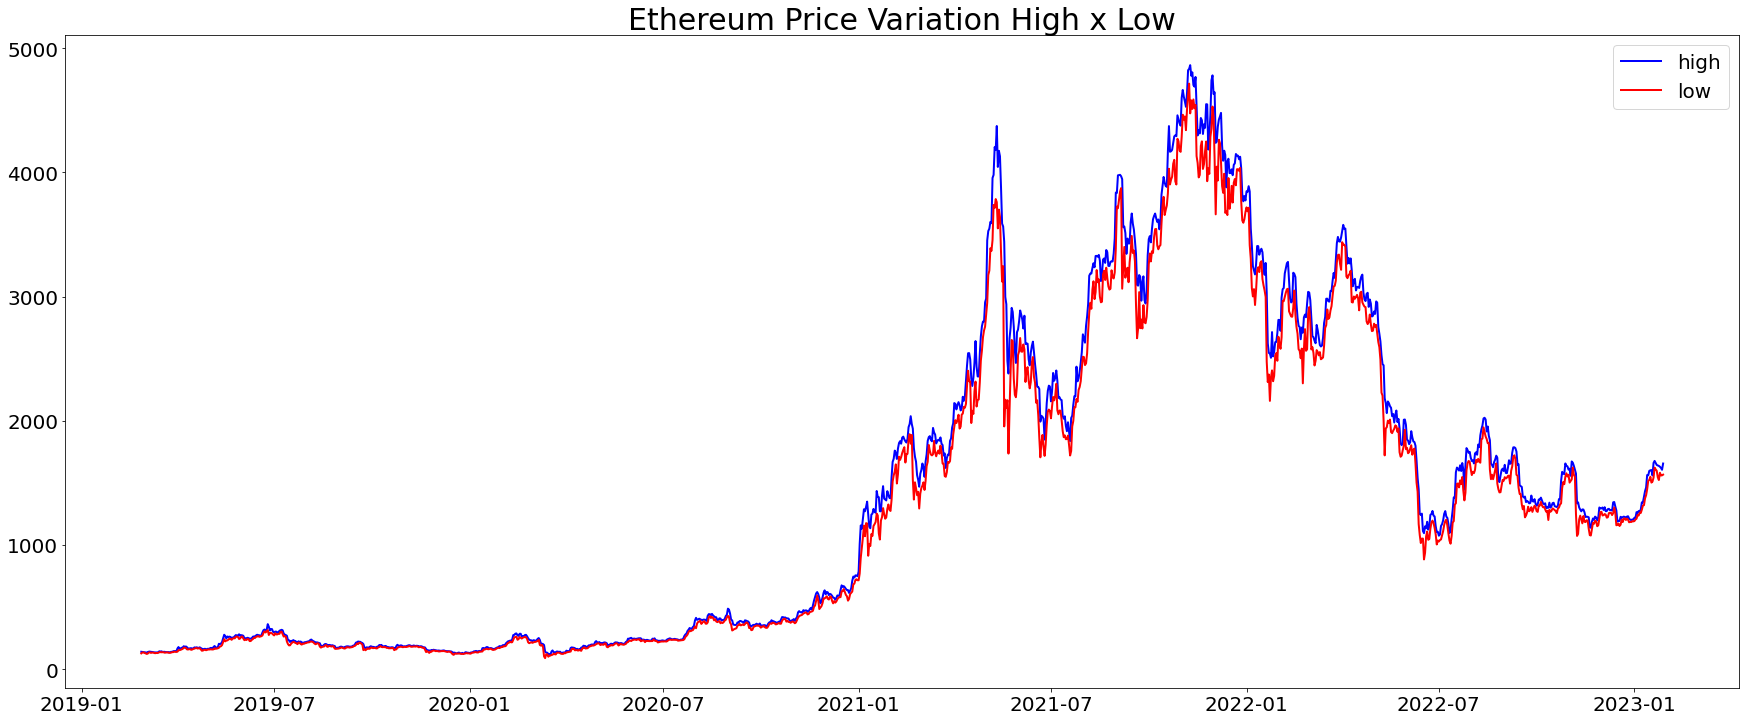

In [47]:
# Line plot Ethereum High x Low Prices
plt.figure(figsize = (30,12))
plt.plot('date', 
         'high', 
         data = df_pandas_Dates, 
         marker = '', 
         markersize = 12, 
         color = 'blue', 
         linewidth = 2)
plt.plot('date',
         'low',
         data = df_pandas_Dates,
         markersize = 12,
         color = 'red',
         linewidth = 2)

# Set the font size axis
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

# Title
plt.title('Ethereum Price Variation High x Low', fontsize = 30)

# legend
plt.legend(fontsize = 20)

# plot show
plt.show()

Let's now generate a plot of lines showing the relationship between Open price and High price:

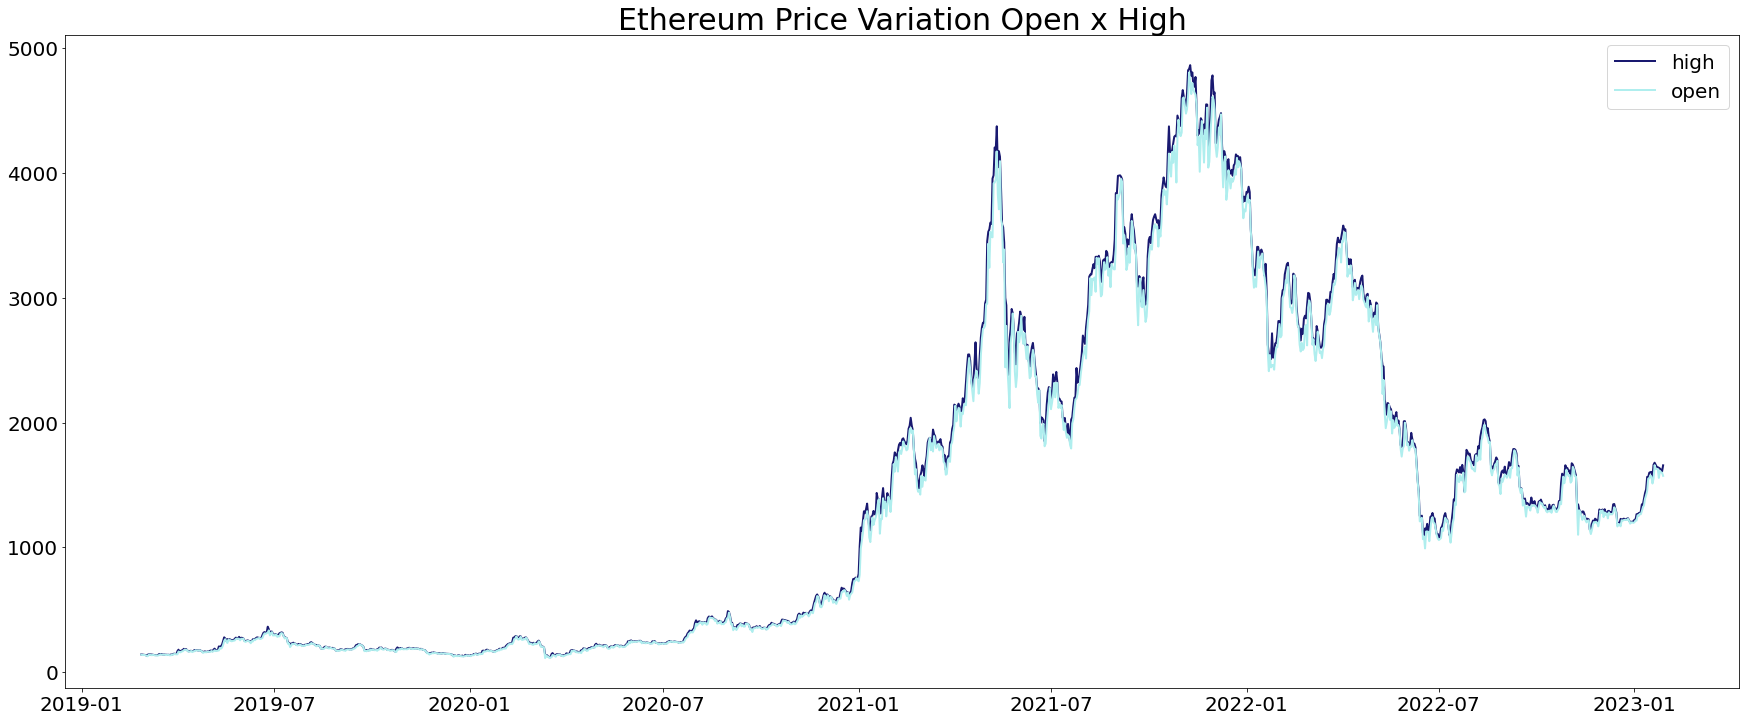

In [48]:
# Line plot Ethereum Open x High Prices
plt.figure(figsize = (30,12))
plt.plot('date', 
         'high', 
         data = df_pandas_Dates, 
         marker = '', 
         markersize = 12, 
         color = 'midnightblue', 
         linewidth = 2)
plt.plot('date',
         'open',
         data = df_pandas_Dates,
         markersize = 12,
         color = 'paleturquoise',
         linewidth = 2)

# Set the font size axis
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

# Title
plt.title('Ethereum Price Variation Open x High', fontsize = 30)

# legend
plt.legend(fontsize = 20)

# plot show
plt.show()

It seems according to the plot above there is low price variation .

We can affirm with the plot above that they represent about the same information. We already observed in the correlation plot.

It does not make sense use those two variables in the machine learning model, we will choose one of them.

Let's create a histogram with Open Prices:

<AxesSubplot:ylabel='Frequency'>

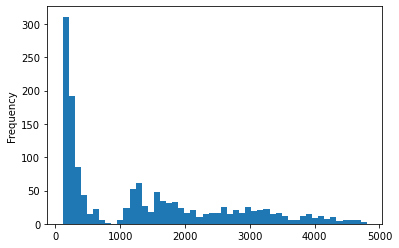

In [49]:
# Histogram for Open Prices
df_pandas_Dates.open.plot(kind = 'hist', bins = 50)

We can observe an anomaly in the beginning of the series. After that there is a certain pattern, this is a possible outlier. 

Let's create a plot of our target variable:

## Feature Engineering

In [124]:
# Assembling the features into a vector column
# Selecting only numerical columns to the vector
# df_numCols = df_date_year['open', 'high', 'low', 'close', 'day_of_week']
assembler = VectorAssembler(inputCols = ['open', 'high', 'low'],
                            outputCol = 'features')

In [125]:
# Creates the feature vector dataframe
df_assembled = assembler.transform(df_ethereum)

In [126]:
df_assembled.show(5, truncate = False)

+----------+------------------+------------------+------------------+------------------+-------------------+----------------------------------------------------------+
|timestamp |open              |high              |low               |close             |dateTime           |features                                                  |
+----------+------------------+------------------+------------------+------------------+-------------------+----------------------------------------------------------+
|1674950400|1572.3284596132792|1656.7355616828581|1567.2505554599768|1646.3975912377196|2023-01-28 21:00:00|[1572.3284596132792,1656.7355616828581,1567.2505554599768]|
|1674864000|1597.7988155004043|1606.3350413485482|1561.682974973507 |1573.408539327373 |2023-01-27 21:00:00|[1597.7988155004043,1606.3350413485482,1561.682974973507] |
|1674777600|1601.1149228955474|1621.57130439506  |1560.42851740301  |1597.8047515450849|2023-01-26 21:00:00|[1601.1149228955474,1621.57130439506,1560.4285174030

It's not necessary to apply any kind of normalization in the data since they are at the same scale.

We will split our dataset into train and test:

In [127]:
# Splitting dataset into train and test
train_data, test_data = df_assembled.randomSplit([0.7, 0.3], seed = random_seed)

In [128]:
# Checking train data type
type(train_data)

pyspark.sql.dataframe.DataFrame

In [129]:
# Checking training data columns
train_data.columns

['timestamp', 'open', 'high', 'low', 'close', 'dateTime', 'features']

## Building and Training the first version of the model

Here we define the first version of the model, in which we indicate the input vector for the model (features), target variable (close) which we do not normalize and the definition of the column name with the values to be predicted by this model:

In [130]:
# Building a regression model
model1_LinReg = (LinearRegression(featuresCol='features',
                                  labelCol='close',
                                  predictionCol='predicted_price',
                                  maxIter=100,
                                  regParam=0.3,
                                  elasticNetParam=0.8,
                                  standardization=False))

In [131]:
# Training the model
model1 = model1_LinReg.fit(train_data)

## Evaluation of the first version of the model

Let's check if the first version of the model presents a good performance.

In [134]:
# Predictions with test dataset
predictions1 = model1.transform(test_data)

Let's check what the model predicted

In [135]:
# Selecting the columns
pred_data1 = predictions1.select('predicted_price', 'close').show(10)

+-------------------+------------------+
|    predicted_price|             close|
+-------------------+------------------+
|-392.22975698180517| 136.6016635502296|
|-397.08378128329423|133.41201623674613|
| -400.1760766946203|137.99084538444393|
|-391.54217794233296|139.76829395789804|
|-389.73270681952135|137.71462733948798|
| -393.5496433660105|138.25653686416675|
|-399.69953996225127|134.32495091204146|
| -395.4677311616055|137.44905027019863|
|-394.09324602887693|136.58334253147905|
| -390.6338693513983|138.28167591760413|
+-------------------+------------------+
only showing top 10 rows



The models apparently shows a good performance 

Let's obtain an evaluation metric of the model, here we will calculate MAE (Mean Absolute Error):

In [136]:
# Mean Absolute Error
print('Mean Absolute Error (MAE) in the test data: {0}'.format(model1.summary.meanAbsoluteError))

Mean Absolute Error (MAE) in the test data: 460.06799064153364


Let's create the evaluator where we indicate the original label, the predicted value and the metric we want to use, in this case of root mean square error (RMSE):

In [137]:
# Create an evaluator for the regression model
evaluator = RegressionEvaluator(labelCol = 'close',
                                predictionCol = 'predicted_price',
                                metricName = 'rmse')

Now we apply the  evaluator to calculate RMSE for the model 1

In [138]:
# Calculating the RMSE
rmseM1 = evaluator.evaluate(predictions1)
print('Root Mean Squared Error (RMSE) in the test data = %g' %rmseM1)

Root Mean Squared Error (RMSE) in the test data = 545.314


In [139]:
# Extracting the predictions
pred_Res1 = model1.evaluate(test_data)

Let's prepare the actual values and predicted values in the target variable:

In [140]:
# Converting the actual values (Y) to Pandas format
Y = pred_Res1.predictions.select('close').toPandas()

In [141]:
# Predicted values (_Y) being converted to Pandas format
_Y = pred_Res1.predictions.select('predicted_price').toPandas()

We will plot those data

C:\Users\drena\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\drena\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

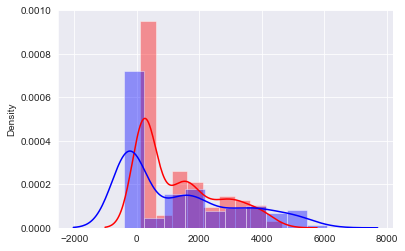

In [147]:
# Distribution of actual values x predicted values
sns.set_style('darkgrid')
axl = sns.distplot(Y, color = 'r', label = 'Actual Values')
sns.distplot(_Y, color = 'b', label = 'Predicted Values')

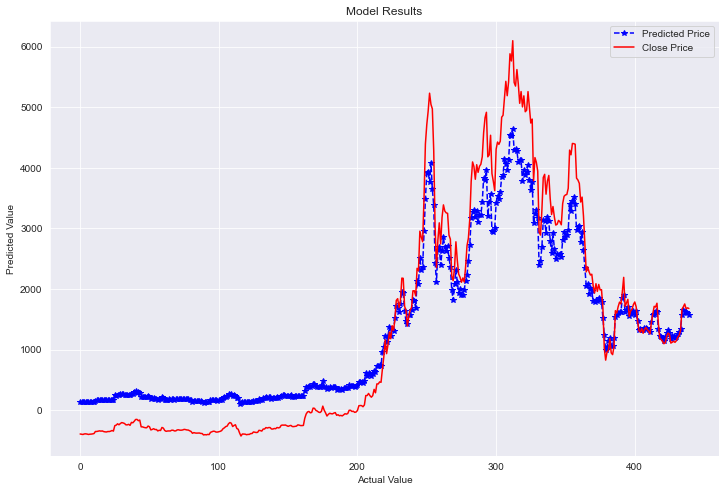

In [144]:
# Joining plots with actual values x predicted values
plt.figure(figsize = (12,8))
plt.plot(Y, color = 'blue', marker = '*', linestyle = 'dashed', label = 'Predicted Price')
plt.plot(_Y, color = 'red', label = 'Close Price')
plt.title('Model Results')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.legend()

We have have an interesting result which the model started predicting prices over the actual price and from a certain point reverted that trend predicting prices lower than the actual prices.
Interesting insight is that in the end of this series the model apparently found a pattern and started matching the values.

Our metrics are unaceptably high: <b>MAE = 460</b> and <b>RMSE = 545</b>.

Look only to those metrics, without a plot with the progression of the prediction values we could discard this model easily.

Maybe with more data could be possible to affirm that the model was able to find a pattern.

Let's build a second model version in order to compare performances between those models

## Building and training a second version of the model with hyperparameter optimization

In this second version we will concern with hyperparameter optimization

In [148]:
# Building a new model
model2 = (LinearRegression(featuresCol='features',
                           labelCol='close',
                           predictionCol='predicted_price'))

We wll create a parameters grid. In that we will evaluate two options for the hyperparameter "maxIter" which we will apply the values 80 and 160:

In [149]:
# Creates a grid for hyperparameter optimization
grid = ParamGridBuilder().addGrid(model2.maxIter, [80, 160]).build()

In [150]:
# Creates the evaluator (it will be used for cross-validation)
evaluator = RegressionEvaluator(labelCol='close',
                                predictionCol='predicted_price',
                                metricName='rmse')

And we created the cross validator, because in practice we will create a series of models testing different combinations of hyperparameters.

The cross validator will take the model, it will put the first combination of hyperparameters, it will use the evaluator and do the parallelism in 2:

In [151]:
# Creates the Cross Validator
crossVal = CrossValidator(estimator=model2, estimatorParamMaps=grid, evaluator=evaluator, parallelism=2)

After this step we will take the train data and split it in train and test (the same way we use to do with scikit-learn cross validation):

In [152]:
# Trains the Cross Validator
cvModel = crossVal.fit(train_data)

Exception ignored in: <function JavaWrapper.__del__ at 0x0000017BC0928C10>
Traceback (most recent call last):
  File "C:\Users\drena\anaconda3\lib\site-packages\pyspark\ml\wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'VectorAssembler' object has no attribute '_java_obj'


In [153]:
# Extracts the best model calculated by the CrossValidator
model2 = cvModel.bestModel

## Second version of the Model evaluation

In [154]:
# Predictions with test data
predictions2= model2.transform(test_data)

In [155]:
# Selects the columns
pred_Res2 = predictions2.select('predicted_price', 'close').show(10)

+------------------+------------------+
|   predicted_price|             close|
+------------------+------------------+
|139.63643097872185| 136.6016635502296|
|133.76465431419038|133.41201623674613|
| 137.6148213435205|137.99084538444393|
|139.16983352470794|139.76829395789804|
| 139.8662196538085|137.71462733948798|
| 139.1341749859521|138.25653686416675|
|132.78073798674092|134.32495091204146|
| 137.9405220042766|137.44905027019863|
|136.99239026718925|136.58334253147905|
|138.25838149210094|138.28167591760413|
+------------------+------------------+
only showing top 10 rows



We could observe a better performance in this model.

In [156]:
# Mean Absolute Error
print('MAE {0}'.format(model2.summary.meanAbsoluteError))

MAE 19.04115591408097


MAE of Model2 is much smaller than the first version

In [157]:
# Evaluator for RMSE
evaluator = RegressionEvaluator(labelCol='close',
                                predictionCol='predicted_price',
                                metricName='rmse')

In [158]:
# Applies the evaluator to calculate the RMSE
rmseM2 = evaluator.evaluate(predictions2)
print('Root Mean Squared Error (RMSE) in the test data = %g' % rmseM2)

Root Mean Squared Error (RMSE) in the test data = 39.6463


RMSE of Model2 is smaller either.

Plot again with the same criteria adopted in the first model

In [159]:
# Extracts the predictions
predR2 = model2.evaluate(test_data)

In [160]:
# Actual Y values being converted to Pandas format
Y = predR2.predictions.select('close').toPandas()

In [161]:
# Predicted Y values being converted to Pandas format
_Y = predR2.predictions.select('predicted_price').toPandas()

C:\Users\drena\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\drena\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

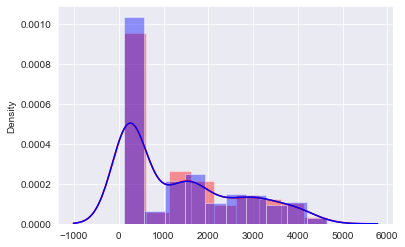

In [162]:
# Plots
sns.set_style('darkgrid')
axl = sns.distplot(Y, color = 'red', label = 'Actual Values')
sns.distplot(_Y, color = 'blue', label = 'Predicted Values')

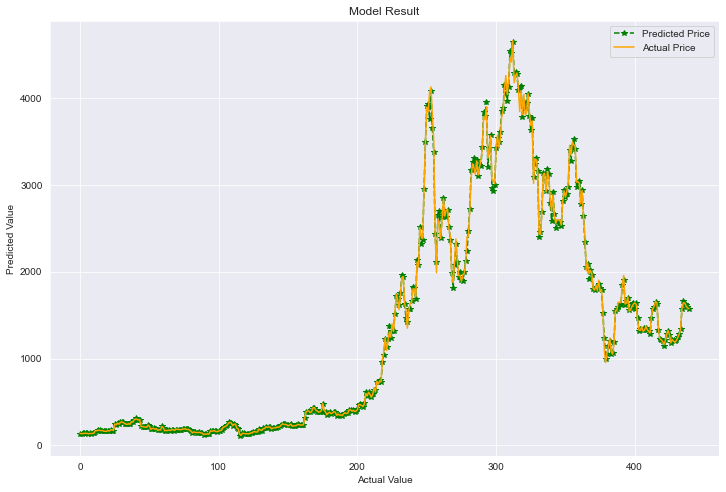

In [163]:
# Plot with actual values x predicted values
plt.figure(figsize = (12, 8))
plt.plot(Y, color = 'green', marker = '*', linestyle = 'dashed', label = 'Predicted Price')
plt.plot(_Y, color = 'orange', label = 'Actual Price')
plt.title('Model Result')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.legend()

We can see that Model2 performed much better than Model1, finding patterns in the data throughout the time series.

## Real Time prediction with the trained model

We will feed the model with new input data.

We will verify the performance in the both models (model 1 and model 2).

In [164]:
# New input data (we will collect a sample data)
new_data = [[1656.4474637252115,1689.765759926666,1640.0494330602953], [1706.2,1721.35712109829,1616.6500264607175]]

In [165]:
# Prepare Pandas dataframe
df_NewData = pd.DataFrame(new_data, columns = ['open', 'high', 'low'])

In [166]:
# Viewing
df_NewData    

,open,high,low
0,1656.447464,1689.765760,1640.049433
1,1706.200000,1721.357121,1616.650026


In [167]:
# Converting Pandas dataframe into Spark dataframe
df_NewData_Spark = spark_session.createDataFrame(df_NewData)

In [168]:
# Schema
df_NewData_Spark.printSchema()

root
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)



In [169]:
# Viewing
df_NewData_Spark.show()

+------------------+-----------------+------------------+
|              open|             high|               low|
+------------------+-----------------+------------------+
|1656.4474637252115|1689.765759926666|1640.0494330602953|
|            1706.2| 1721.35712109829|1616.6500264607175|
+------------------+-----------------+------------------+



Preparing attribute vector again:

In [170]:
# Creates features vector dataframe
df_assembled = assembler.transform(df_NewData_Spark)

In [172]:
# Viewing
df_assembled.show(truncate = False)

+------------------+-----------------+------------------+---------------------------------------------------------+
|open              |high             |low               |features                                                 |
+------------------+-----------------+------------------+---------------------------------------------------------+
|1656.4474637252115|1689.765759926666|1640.0494330602953|[1656.4474637252115,1689.765759926666,1640.0494330602953]|
|1706.2            |1721.35712109829 |1616.6500264607175|[1706.2,1721.35712109829,1616.6500264607175]             |
+------------------+-----------------+------------------+---------------------------------------------------------+



Make Predictions with the <b>model1</b>:

In [178]:
# Making new predictions with the new input data, using model1
predictionsM1 = model1.transform(df_assembled)

In [179]:
# Print the predictions
predM1_NewData = predictionsM1.select('predicted_price').show()

+------------------+
|   predicted_price|
+------------------+
|1794.9562162248226|
|1800.1290675552855|
+------------------+



Looking at to the historical Ethereum database (close to the period of this analysis) we can see how good or not our Model's performance was:

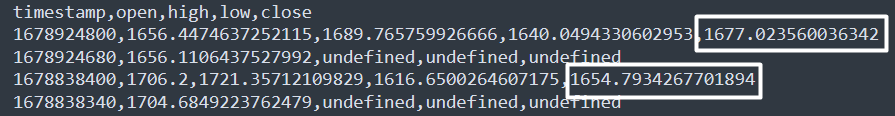

Let's make the same using the <b>model2</b>:

In [175]:
# Making new predictions with the new input data, using model2
predictionsM2 = model2.transform(df_assembled)

In [177]:
# Print the predictions
predM2_NewData = predictionsM2.select('predicted_price').show()

+------------------+
|   predicted_price|
+------------------+
|1669.0145752684336|
|1651.3985183896575|
+------------------+



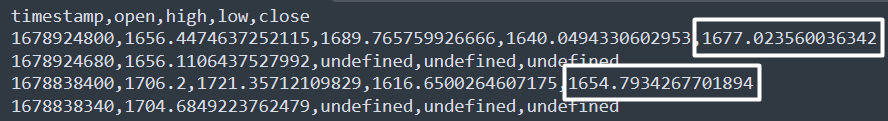

As we expected, we could observe a pretty better performance in the <b>model2</b> (hyperparameter tuned) 

In [180]:
# Finishing the spark session
spark_session.stop()